# Deep Learning Final Project: Multimodal Sentiment Analysis

Team Members:
- Mohammadreza Estarki  
ID: 400209184
- Sajad Hosseini  
ID: 400301997
- Kasra Kamali  
ID: 400201648

# Phase One

In [ ]:
# Upgrade gdown to work properly.
!pip install --upgrade --no-cache-dir gdown
# Install MediaPipe for face detection.
!pip install mediapipe
# Install Einops for PRIME tensor operations.
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 49.9 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.1.21 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import zipfile

import gdown
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                             recall_score)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.models import ResNet50_Weights
from torchvision.transforms import (ColorJitter, GaussianBlur,
                                    RandomHorizontalFlip, RandomRotation,
                                    Resize, ToPILImage, ToTensor)

First, we need to download the Multimodal Sentiment Chat Translation Dataset (MSCTD).

In [ ]:
# Download the image dataset.
# train data
# original link
!gdown 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
# alternative link
if not(os.path.isfile('./train_ende.zip')):
    print("Using the alternative link...")
    !gdown 1KlgzJMXqUwGLBP7aQW9C69UDS0bXvDQn


# dev data
# original link
!gdown 12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA
# alternative link
if not(os.path.isfile('./dev.zip')):
    print("Using the alternative link...")
    !gdown 1-4UxUq_KJKyebCM5ngG_F_COSrpO3fEM


# test data
# original link
!gdown 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W
# alternative link
if not(os.path.isfile('./test.zip')):
    print("Using the alternative link...")
    !gdown 1--0w9CvsR6aUYmj1AK4K8Yjt9UgdckeZ

Downloading...
From: https://drive.google.com/uc?id=1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
To: /content/train_ende.zip
100% 2.90G/2.90G [00:16<00:00, 181MB/s]
Downloading...
From: https://drive.google.com/uc?id=12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA
To: /content/dev.zip
100% 638M/638M [00:04<00:00, 139MB/s]
Downloading...
From: https://drive.google.com/uc?id=1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W
To: /content/test.zip
100% 641M/641M [00:05<00:00, 114MB/s] 


In [ ]:
# Downlaod text files from github.
!git clone https://github.com/XL2248/MSCTD

# Move relevant files to ./data
!mkdir ./data
!mv /content/MSCTD/MSCTD_data/ende /content/data/text

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.


In [ ]:
# Unzip the train images.
zip_ref = zipfile.ZipFile("./train_ende.zip", 'r')
zip_ref.extractall("./data")
zip_ref.close()

# Unzip the dev images.
zip_ref = zipfile.ZipFile("./dev.zip", 'r')
zip_ref.extractall("./data")
zip_ref.close()

# Unzip the test images.
zip_ref = zipfile.ZipFile("./test.zip", 'r')
zip_ref.extractall("./data")
zip_ref.close()

In [ ]:
# Rename train_ende directory to train.
!mv ./data/train_ende ./data/train

# Remove redundant files.
!rm -r MSCTD
!rm ./data/text/german*.txt
!rm train_ende.zip
!rm dev.zip
!rm test.zip

In [ ]:
# Defining the custom dataloader class.
class MSCTD(torch.utils.data.Dataset):
    def __init__(self, data_path, partition, transform=None, target_transform=None, get_mode = 'utterance', shuffle=False, random_seed=None):
        self.data_path = data_path
        self.partition = partition
        self.imgs_path = os.path.join(data_path, partition)
        self.utterance_path = os.path.join(data_path, 'text', 'english_'+partition+'.txt')
        self.sentiment_path = os.path.join(data_path, 'text', 'sentiment_'+partition+'.txt')
        self.dialogue_path = os.path.join(data_path, 'text', 'image_index_'+partition+'.txt')

        self.transform = transform
        self.target_transform = target_transform
        self.get_mode = get_mode
        self.shuffle = shuffle

        # Read the utterance indices that form a dialogue for the given partition.
        with open(self.dialogue_path) as f:
            self.dialogue = [np.array(line[1:-2].split(', '), dtype=int) for line in f]
            f.close()

        # Read the English utterances for the given partition.
        with open(self.utterance_path) as f:
            self.utterance = [line.rstrip('\n') for line in f]
        f.close()

        # Read the sentiment labels for the given partition.
        self.sentiment_labels = np.loadtxt(self.sentiment_path, dtype=int)

        # Generate shuffling indices.
        rng = np.random.default_rng(seed=random_seed)
        
        self.shfl_idx_dlg = np.arange(len(self.dialogue))
        rng.shuffle(self.shfl_idx_dlg)

        self.shfl_idx_utt = np.arange(len(self.utterance))
        rng.shuffle(self.shfl_idx_utt)

    def __len__(self):
        if self.get_mode == 'utterance':
            return len(self.utterance)
        elif self.get_mode == 'dialogue':
            return len(self.dialogue)
        else:
            return None

    def __getitem__(self, idx):
        if self.get_mode == 'utterance':
            if self.shuffle:
                idx = self.shfl_idx_utt[idx]

            img_path = os.path.join(self.imgs_path, str(idx)+'.jpg')
            image = read_image(img_path)
            utterance = self.utterance[idx]
            sentiment = self.sentiment_labels[idx]

            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                sentiment = self.target_transform(sentiment)

            return image, utterance, sentiment

        elif self.get_mode == 'dialogue':
            if self.shuffle:
                idx = self.shfl_idx_dlg[idx]

            images = []
            utterances = []
            sentiments = []

            for i in self.dialogue[idx]:
                img_path = os.path.join(self.imgs_path, str(i)+'.jpg')
                images.append(read_image(img_path))
                utterances.append(self.utterance[i])
                sentiments.append(self.sentiment_labels[i])

            return images, utterances, sentiments

        else:
            return None

In [ ]:
# Instantiate a MSCTD object for each part of the dataset.
train_data = MSCTD(data_path='./data', partition='train', get_mode='utterance')
dev_data = MSCTD(data_path='./data', partition='dev', get_mode='utterance')
test_data = MSCTD(data_path='./data', partition='test', get_mode='utterance')

## Part 1: Analysis of Faces

### Section 1: Method implementation

#### Step 1: Face Detection

In [ ]:
# Defining a custom function for face detection.
def face_detector(data, model_selection=1, min_confidence=0.5, transform = T.Resize([224,224]), threshold = 5):
  # MediaPipe Face Detection.
  mp_face_detection = mp.solutions.face_detection

  face_dataset = []
  face_score =[]
  face_sentiment =[]
  with mp_face_detection.FaceDetection(model_selection = model_selection, min_detection_confidence = min_confidence) as face_detection:
      for i in range(len(data)):
          faces = []
          score =[]
          sentiment =[]
          img,_,sen = data[i]
          results = face_detection.process(img.permute(1,2,0).numpy())
          if not results.detections:
              # Append None so the length of face dataset gets equal to length of train data.
              face_dataset.append(None)
              face_score.append(None)
              face_sentiment.append(None)
              continue
          for i , detection in enumerate(results.detections):
              # If the number of detected faces is greater than threshold, ignore the rest of them.
              if i < threshold:
                xmin = max(0, detection.location_data.relative_bounding_box.xmin)
                ymin = max(0, detection.location_data.relative_bounding_box.ymin)
                width = detection.location_data.relative_bounding_box.width
                height = detection.location_data.relative_bounding_box.height

                x = round(img.shape[2]*xmin)
                y = round(img.shape[1]*ymin)
                w = round(img.shape[2]*width)
                h = round(img.shape[1]*height)

                face = transform(img[:, y:y+h, x:x+w])
                faces.append(face)
                score.append(torch.tensor([detection.score], dtype = torch.float))
                sentiment.append(torch.tensor([sen], dtype = torch.uint8))

          face_dataset.append(faces)
          face_score.append(score)
          face_sentiment.append(sentiment)
          del(faces)
          del(score)
          del(sentiment)
  return face_dataset, face_sentiment, face_score

In [ ]:
# Face detection for train and dev datasets.
# This takes about 5 min for the train data and 1 min for the dev/test data.
train_face, train_face_sentiment, train_face_score = face_detector(train_data, transform = T.Resize([100,100]), threshold = 5)
dev_face, dev_face_sentiment, dev_face_score = face_detector(dev_data, transform = T.Resize([100,100]), threshold = 5)
test_face, test_face_sentiment, test_face_score = face_detector(test_data, transform = T.Resize([100,100]), threshold = 5)

In [ ]:
# Create a new dataset based on the train faces.
len_train_face = 0
for faces in train_face:
  if faces:
    len_train_face += len(faces)

train_faces = torch.zeros(len_train_face, 3, train_face[0][0].shape[1], train_face[0][0].shape[2], dtype=torch.uint8)
train_face_sentiments = torch.zeros(len_train_face, dtype=torch.uint8)

k = 0
for i in range(len(train_face)):
  if train_face[i]:
    for j in range(len(train_face[i])):
      train_faces[k] = train_face[i][j]
      train_face_sentiments[k] = train_face_sentiment[i][j]
      k += 1

train_face_dataset = torch.utils.data.TensorDataset(train_faces, train_face_sentiments)

In [ ]:
# Create a new dataset based on the dev faces.
len_dev_face = 0
for faces in dev_face:
  if faces:
    len_dev_face += len(faces)

dev_faces = torch.zeros(len_dev_face, 3, dev_face[0][0].shape[1], dev_face[0][0].shape[2], dtype=torch.uint8)
dev_face_sentiments = torch.zeros(len_dev_face, dtype =torch.uint8)

k = 0
for i in range(len(dev_face)):
  if dev_face[i]:
    for j in range(len(dev_face[i])):
      dev_faces[k] = dev_face[i][j]
      dev_face_sentiments[k] = dev_face_sentiment[i][j]
      k += 1

dev_face_dataset = torch.utils.data.TensorDataset(dev_faces, dev_face_sentiments)

In [ ]:
# Create a new dataset based on the test faces.
len_test_face = 0
for faces in test_face:
  if faces:
    len_test_face += len(faces)

test_faces = torch.zeros(len_test_face, 3, test_face[0][0].shape[1], test_face[0][0].shape[2], dtype=torch.uint8)
test_face_sentiments = torch.zeros(len_test_face, dtype =torch.uint8)

k = 0
for i in range(len(test_face)):
  if test_face[i]:
    for j in range(len(test_face[i])):
      test_faces[k] = test_face[i][j]
      test_face_sentiments[k] = test_face_sentiment[i][j]
      k += 1

test_face_dataset = torch.utils.data.TensorDataset(test_faces, test_face_sentiments)

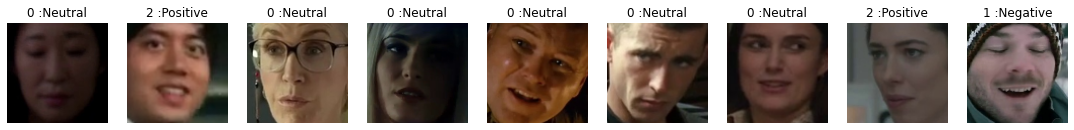

In [ ]:
# Random visualizations from train data
indxs = np.random.default_rng(seed=123).integers(len(train_faces), size=9)
faces = []
face_sentiments = []
for i in indxs:
    face, face_sentiment = train_face_dataset[i]
    faces.append(T.ToPILImage()(face))
    face_sentiments.append(face_sentiment)
sentiment_classes = ['Neutral', 'Negative', 'Positive']
plt.figure(figsize=(19, 19))
for i in range(9):
    plt.subplot(1,9, i+1)
    plt.imshow(faces[i])
    plt.title(f'{face_sentiments[i]} :{sentiment_classes[face_sentiments[i]]}')
    plt.axis('off')

#### Step 2: Sentiment Prediction Using CNN

In [ ]:
# Creating the model
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 32, 3, padding='same')
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, 3, padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv6 = nn.Conv2d(128, 128, 3, padding='same')
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)

        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN = ConvNet().to(device)
print(f'\nDevice: {device}')
print("Network Architecture:")
print(CNN)


Device: cuda
Network Architecture:
ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)


In [ ]:
# Computing class weights to balance training data.
class_weights = compute_class_weight('balanced', classes=torch.unique(train_face_dataset[:][1]).numpy(), y=train_face_dataset[:][1].numpy())
class_weights = torch.tensor(class_weights,dtype=torch.float)
print("Class Weights:")
print(dict(zip(torch.unique(train_faces[:][1]).numpy(), class_weights.numpy())))

class_weights = class_weights.to(device)

Class Weights:
{0: 0.9901054, 1: 0.8580231, 2: 1.2128023}


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # Normalizing the input and sending it to device.
        X = X.float()/255
        (X, y) = (X.to(device), y.to(device))
        # Compute prediction and loss.
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(X)
        if batch % 100 == 0:
            current = batch * len(X)
            print(f"loss: {running_loss/((batch+1)*len(X)):>7f}  [{current:>5d}/{size:>5d}]")


def eval_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.float()/255
            (X, y) = (X.to(device), y.to(device))
            pred = model(X)
            valid_loss += loss_fn(pred, y).item() * X.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    valid_loss /= size
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Average loss: {valid_loss:>8f} \n")

In [ ]:
batch_size = 32
lr = 1e-4
epochs = 5
# Creating data loaders.
train_dataloader = DataLoader(train_face_dataset, shuffle=True, batch_size=batch_size, num_workers=2)
dev_dataloader = DataLoader(dev_face_dataset, shuffle=False, batch_size=batch_size, num_workers=2)
test_dataloader = DataLoader(test_face_dataset, shuffle=False, batch_size=batch_size, num_workers=2)
optimizer = torch.optim.Adam(CNN.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(CNN.parameters(), lr=lr)
# optimizer = torch.optim.SGD(CNN.parameters(), lr=lr)
# Defining loss function with obtained class weights.
loss_fn = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
loss_fn_eval = nn.CrossEntropyLoss(reduction='mean')

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, CNN, loss_fn, optimizer)
    print("Validation Results:")
    eval_loop(dev_dataloader, CNN, loss_fn_eval)
print("Done!")

Epoch 1
-------------------------------
loss: 1.107696  [    0/19913]
loss: 1.098254  [ 3200/19913]
loss: 1.097499  [ 6400/19913]
loss: 1.097173  [ 9600/19913]
loss: 1.097186  [12800/19913]
loss: 1.097271  [16000/19913]
loss: 1.097290  [19200/19913]
Validation Results:
Accuracy: 35.8%, Average loss: 1.098528 

Epoch 2
-------------------------------
loss: 1.101607  [    0/19913]
loss: 1.097022  [ 3200/19913]
loss: 1.096271  [ 6400/19913]
loss: 1.096758  [ 9600/19913]
loss: 1.096818  [12800/19913]
loss: 1.097070  [16000/19913]
loss: 1.097174  [19200/19913]
Validation Results:
Accuracy: 35.9%, Average loss: 1.098548 

Epoch 3
-------------------------------
loss: 1.096349  [    0/19913]
loss: 1.096717  [ 3200/19913]
loss: 1.097033  [ 6400/19913]
loss: 1.097126  [ 9600/19913]
loss: 1.097220  [12800/19913]
loss: 1.097270  [16000/19913]
loss: 1.096949  [19200/19913]
Validation Results:
Accuracy: 35.9%, Average loss: 1.098521 

Epoch 4
-------------------------------
loss: 1.100984  [    0/1

In [ ]:
# Saving the CNN model.
torch.save(CNN, './CNN.h5')

In [ ]:
# Loading the trained CNN model.
!gdown 1jN_zibuobjyCgGXCtcVaNzcVkKwodnKI
# Check if CUDA is available. 
if torch.cuda.is_available():
    CNN = torch.load("./CNN.h5")
else:
    CNN = torch.load("./CNN.h5", map_location=torch.device('cpu'))

In [ ]:
# CNN evaluation
print("Evaluation results for train data:")
eval_loop(train_dataloader, CNN, loss_fn_eval)
print("Evaluation results for dev data:")
eval_loop(dev_dataloader, CNN, loss_fn_eval)
print("Evaluation results for test data:")
eval_loop(test_dataloader, CNN, loss_fn_eval)

Evaluation results for train data:
Accuracy: 39.7%, Average loss: 1.095551 

Evaluation results for dev data:
Accuracy: 35.8%, Average loss: 1.098892 

Evaluation results for test data:
Accuracy: 39.7%, Average loss: 1.096178 



#### Step 3: Combining Face Detection and CNN

Now, we define a function to combine the face detection network with our trained CNN.  
Note: We randomly assign a prediction to images without any detected faces, with the probability of each class being proportional to the class weights of the training data.

In [ ]:
def face_sentiment_detector(img, model, class_weights=[1]*3, min_conf=0.5, threshold=5, transform=T.Resize([100, 100])):
    mp_face_detection = mp.solutions.face_detection
    faces = []
    scores =[]
    face_num = 0
    preds = torch.zeros((threshold, 3))

    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=min_conf) as face_detection:
        results = face_detection.process(img.permute(1,2,0).numpy())

    if not results.detections:
        # Randomly choose sentiment proportional to class weights.
        x = 1/(1/class_weights[0] + 1/class_weights[1] + 1/class_weights[2])
        pred = torch.rand(1).to(device)

        if pred>=0 and pred<x/class_weights[0]:
            pred = torch.tensor([1., 0, 0])
        elif pred>=x/class_weights[0] and pred<x/class_weights[0]+x/class_weights[1]:
            pred = torch.tensor([0, 1., 0])
        else:
            pred = torch.tensor([0, 0, 1.])
    else:
        for i , detection in enumerate(results.detections):
            if i < threshold:
                xmin = max(0, detection.location_data.relative_bounding_box.xmin)
                ymin = max(0, detection.location_data.relative_bounding_box.ymin)
                width = detection.location_data.relative_bounding_box.width
                height = detection.location_data.relative_bounding_box.height

                x = round(img.shape[2]*xmin)
                y = round(img.shape[1]*ymin)
                w = round(img.shape[2]*width)
                h = round(img.shape[1]*height)

                f = transform(img[:, y:y+h, x:x+w])

                faces.append(f)
                scores.append(torch.tensor([detection.score], dtype = torch.float))

        with torch.no_grad():
            i = min(i, threshold-1)
            for j in range(i+1):
                preds[j] = model((faces[j][None,...]/255).to(device))
        preds = preds[0:i+1,...]
        scores = torch.tensor(scores)
        pred = scores@preds/sum(scores)
        face_num = len(scores)

    return pred, face_num

Performance evaluation of the face sentiment detector:

In [ ]:
preds_train = torch.zeros(len(train_data))
for i in range(len(train_data)):
    preds_train[i] = face_sentiment_detector(train_data[i][0], CNN, class_weights)[0].argmax()

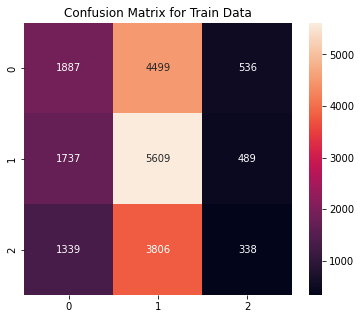

Train Accuracy: 38.71 %
Train Precision: 34.38 %
Train Recall: 35.00 %


In [ ]:
train_acc = accuracy_score(train_data.sentiment_labels, preds_train.numpy())
train_prc = precision_score(train_data.sentiment_labels, preds_train.numpy(), average='macro')
train_rcl = recall_score(train_data.sentiment_labels, preds_train.numpy(), average='macro')
train_cf = confusion_matrix(train_data.sentiment_labels, preds_train.numpy())

plt.figure(figsize=(6, 5))
sns.heatmap(train_cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Train Data')
plt.show()

print(f"Train Accuracy: {train_acc*100:.2f} %")
print(f"Train Precision: {train_prc*100:.2f} %")
print(f"Train Recall: {train_rcl*100:.2f} %")

In [ ]:
preds_dev = torch.zeros(len(dev_data))
for i in range(len(dev_data)):
    preds_dev[i] = face_sentiment_detector(dev_data[i][0], CNN, class_weights)[0].argmax()

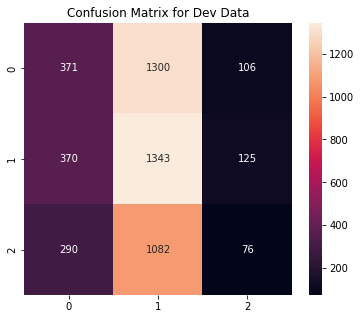

Dev Accuracy: 35.35 %
Dev Precision: 32.26 %
Dev Recall: 33.07 %


In [ ]:
dev_acc = accuracy_score(dev_data.sentiment_labels, preds_dev.numpy())
dev_prc = precision_score(dev_data.sentiment_labels, preds_dev.numpy(), average='macro')
dev_rcl = recall_score(dev_data.sentiment_labels, preds_dev.numpy(), average='macro')
dev_cf = confusion_matrix(dev_data.sentiment_labels, preds_dev.numpy())

plt.figure(figsize=(6, 5))
sns.heatmap(dev_cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Dev Data')
plt.show()

print(f"Dev Accuracy: {dev_acc*100:.2f} %")
print(f"Dev Precision: {dev_prc*100:.2f} %")
print(f"Dev Recall: {dev_rcl*100:.2f} %")

In [ ]:
preds_test = torch.zeros(len(test_data))
for i in range(len(test_data)):
    preds_test[i] = face_sentiment_detector(test_data[i][0], CNN, class_weights)[0].argmax()

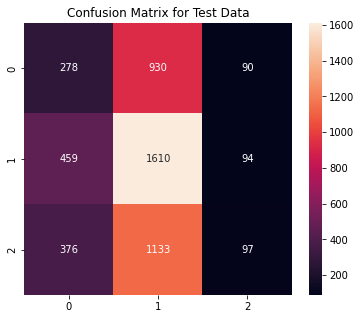

Test Accuracy: 39.18 %
Test Precision: 34.44 %
Test Recall: 33.96 %


In [ ]:
test_acc = accuracy_score(test_data.sentiment_labels, preds_test.numpy())
test_prc = precision_score(test_data.sentiment_labels, preds_test.numpy(), average='macro')
test_rcl = recall_score(test_data.sentiment_labels, preds_test.numpy(), average='macro')
test_cf = confusion_matrix(test_data.sentiment_labels, preds_test.numpy())

plt.figure(figsize=(6, 5))
sns.heatmap(test_cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Test Data')
plt.show()

print(f"Test Accuracy: {test_acc*100:.2f} %")
print(f"Test Precision: {test_prc*100:.2f} %")
print(f"Test Recall: {test_rcl*100:.2f} %")

### Section 2: Data Augmentation

#### Step 1: Generate Images With PRIME

In [ ]:
!git clone https://github.com/amodas/PRIME-augmentations.git

Cloning into 'PRIME-augmentations'...
remote: Enumerating objects: 605, done.
remote: Counting objects: 100% (605/605), done.
remote: Compressing objects: 100% (363/363), done.
remote: Total 605 (delta 238), reused 576 (delta 220), pack-reused 0
Receiving objects: 100% (605/605), 10.88 MiB | 15.49 MiB/s, done.
Resolving deltas: 100% (238/238), done.


In [ ]:
!mv ./PRIME-augmentations/utils ./utils

In [ ]:
!rm -r ./PRIME-augmentations/

In [ ]:
from utils.color_jitter import RandomSmoothColor
from utils.diffeomorphism import Diffeo
from utils.prime import GeneralizedPRIMEModule, PRIMEAugModule
from utils.rand_filter import RandomFilter

In [ ]:
# PRIME Augmentation Parameters
# Spatial Domain
diffeo_sT = 1.
diffeo_rT = 1.
diffeo_scut = 1.
diffeo_rcut = 1.
diffeo_cutmin = 2
diffeo_cutmax = 500
diffeo_alpha = 1.0

# Color Domain
color_jit_cut = 500
color_jit_T = 0.05
color_jit_max_freqs = 20

# Spectral Domain
rand_filter_kernel_size = 3
rand_filter_sigma = 4.0

augmix_mixture_width = 3
augmix_mixture_depth = -1
augmix_no_jsd = True

dataset_mean = torch.tensor([0, 0, 0])
dataset_std = torch.tensor([1, 1, 1])

# dataset_mean = torch.tensor([0.3204, 0.2292, 0.1989])
# dataset_std = torch.tensor([0.0499, 0.0505, 0.0513])

In [ ]:
class TransformLayer(torch.nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        mean = torch.as_tensor(mean, dtype=torch.float)[None, :, None, None]
        std = torch.as_tensor(std, dtype=torch.float)[None, :, None, None]
        self.mean = torch.nn.Parameter(mean, requires_grad=False)
        self.std = torch.nn.Parameter(std, requires_grad=False)

    def forward(self, x):
        return x.sub(self.mean).div(self.std)

In [ ]:
def PRIME(img, enable_aug_diffeo=True, enable_aug_color_jit=True, enable_aug_rand_filter=True):
    augmentations = []

    if enable_aug_diffeo:
        diffeo = Diffeo(
            sT=diffeo_sT, rT=diffeo_rT,
            scut=diffeo_scut, rcut=diffeo_rcut,
            cutmin=diffeo_cutmin, cutmax=diffeo_cutmax,
            alpha=diffeo_alpha, stochastic=True
        )
        augmentations.append(diffeo)

    if enable_aug_color_jit:
        color = RandomSmoothColor(
            cut=color_jit_cut, T=color_jit_T,
            freq_bandwidth=color_jit_max_freqs, stochastic=True
        )
        augmentations.append(color)

    if enable_aug_rand_filter:
        filt = RandomFilter(
            kernel_size=rand_filter_kernel_size,
            sigma=rand_filter_sigma, stochastic=True
        )
        augmentations.append(filt)
    
    prime_module = GeneralizedPRIMEModule(
        preprocess=TransformLayer(dataset_mean, dataset_std),
        mixture_width=augmix_mixture_width,
        mixture_depth=augmix_mixture_depth,
        no_jsd=augmix_no_jsd, max_depth=3,
        aug_module=PRIMEAugModule(augmentations),
    )

    return prime_module.forward(img)

In [ ]:
# Create a new train dataset that is altered by PRIME.
train_faces_prime = torch.empty_like(train_faces, dtype=torch.uint8)

for i in range(len(train_faces)):
    train_faces_prime[i] = (PRIME(train_faces[i:i+1]/255)*255).round().type(torch.uint8)

train_face_prime_dataset = torch.utils.data.TensorDataset(train_faces_prime, train_face_sentiments)

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# Create a new dev dataset that is altered by PRIME.
dev_faces_prime = torch.empty_like(dev_faces, dtype=torch.uint8)

for i in range(len(dev_faces)):
    dev_faces_prime[i] = (PRIME(dev_faces[i:i+1]/255)*255).round().type(torch.uint8)

dev_face_prime_dataset = torch.utils.data.TensorDataset(dev_faces_prime, dev_face_sentiments)

In [ ]:
# Create a new test dataset that is altered by PRIME.
test_faces_prime = torch.empty_like(test_faces, dtype=torch.uint8)

for i in range(len(test_faces)):
    test_faces_prime[i] = (PRIME(test_faces[i:i+1]/255)*255).round().type(torch.uint8)

test_face_prime_dataset = torch.utils.data.TensorDataset(test_faces_prime, test_face_sentiments)

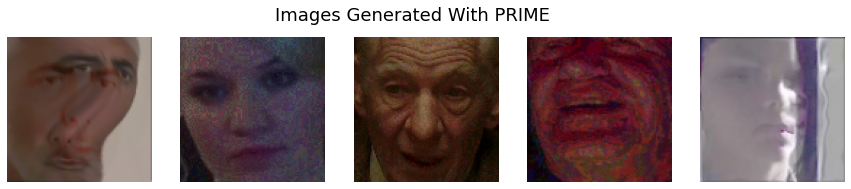

In [ ]:
# Random visualization
indxs = np.random.default_rng(seed=100).integers(len(train_faces), size=5)

plt.figure(figsize=(15, 3))
for i in range(len(indxs)):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_faces_prime[indxs[i]].permute(1,2,0))
    plt.axis('off')

plt.suptitle('Images Generated With PRIME', fontsize=18)
plt.show()

#### Step 2: CNN Evaluation With the New Datasets

In [ ]:
batch_size = 32
train_prime_dataloader = DataLoader(train_face_prime_dataset, batch_size=batch_size)
dev_prime_dataloader = DataLoader(dev_face_prime_dataset, batch_size=batch_size)
test_prime_dataloader = DataLoader(train_face_prime_dataset, batch_size=batch_size)

In [ ]:
print("Evaluation results for train data after being processed by PRIME:")
eval_loop(train_prime_dataloader, CNN, loss_fn_eval)
print("Evaluation results for dev data after being processed by PRIME:")
eval_loop(dev_prime_dataloader, CNN, loss_fn_eval)
print("Evaluation results for test data after being processed by PRIME:")
eval_loop(test_prime_dataloader, CNN, loss_fn_eval)

Evaluation results for train data after being processed by PRIME:
Accuracy: 38.6%, Average loss: 1.098671 

Evaluation results for dev data after being processed by PRIME:
Accuracy: 35.7%, Average loss: 1.100657 

Evaluation results for test data after being processed by PRIME:
Accuracy: 38.6%, Average loss: 1.098671 



As expected, the accuracy of our model is slightly lower on the altered datasets. By inspecting the altered images, we can say the diffomorphism transformations followed by harsh color jitters can completely destroy the information of an image, and thus our model is not capable of predicting the label correctly.

#### Step 3: Training a New Model With Augmented Dataset

In [ ]:
# Combining the training images and create an augmented dataset.
train_faces_aug = torch.cat((train_faces, train_faces_prime))
train_face_sentiments_aug = torch.cat((train_face_sentiments, train_face_sentiments))

train_face_aug_dataset = torch.utils.data.TensorDataset(train_faces_aug, train_face_sentiments_aug)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_AUG = ConvNet().to(device)
print("Network Architecture:")
print(CNN_AUG)
print(f'\nDevice: {device}')

Network Architecture:
ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)

Device: cuda


In [ ]:
batch_size = 32
lr = 1e-4
epochs = 5
# Creating data loader
train_aug_dataloader = DataLoader(train_face_aug_dataset, shuffle=True, batch_size=batch_size, num_workers=2)
dev_dataloader = DataLoader(dev_face_dataset, shuffle=False, batch_size=batch_size, num_workers=2)
test_dataloader = DataLoader(test_face_dataset, shuffle=False, batch_size=batch_size, num_workers=2)
optimizer = torch.optim.Adam(CNN_AUG.parameters(), lr=lr)
# Defining loss function with obtained class weights.
loss_fn = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
loss_fn_eval = nn.CrossEntropyLoss(reduction='mean')

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_aug_dataloader, CNN_AUG, loss_fn, optimizer)
    print("Validation Results:")
    eval_loop(dev_dataloader, CNN_AUG, loss_fn_eval)
print("Done!")

Epoch 1
-------------------------------
loss: 1.096812  [    0/39826]
loss: 1.098926  [ 3200/39826]
loss: 1.098686  [ 6400/39826]
loss: 1.098770  [ 9600/39826]
loss: 1.098751  [12800/39826]
loss: 1.098706  [16000/39826]
loss: 1.098674  [19200/39826]
loss: 1.098725  [22400/39826]
loss: 1.098703  [25600/39826]
loss: 1.098708  [28800/39826]
loss: 1.098686  [32000/39826]
loss: 1.098677  [35200/39826]
loss: 1.098681  [38400/39826]
Validation Results:
Accuracy: 31.9%, Average loss: 1.098899 

Epoch 2
-------------------------------
loss: 1.098051  [    0/39826]
loss: 1.098664  [ 3200/39826]
loss: 1.098648  [ 6400/39826]
loss: 1.098480  [ 9600/39826]
loss: 1.098487  [12800/39826]
loss: 1.098464  [16000/39826]
loss: 1.098491  [19200/39826]
loss: 1.098453  [22400/39826]
loss: 1.098428  [25600/39826]
loss: 1.098470  [28800/39826]
loss: 1.098482  [32000/39826]
loss: 1.098468  [35200/39826]
loss: 1.098492  [38400/39826]
Validation Results:
Accuracy: 36.2%, Average loss: 1.098653 

Epoch 3
--------

In [ ]:
# Saving the CNN_AUG model.
torch.save(CNN_AUG, './CNN_AUG.h5')

In [ ]:
# Loading the trained model.
!gdown 1-0vz2lbHeIK_ivHlDB2tYqtvZnSo4nze
# Check if CUDA is available. 
if torch.cuda.is_available():
    CNN_AUG = torch.load("./CNN_AUG.h5")
else:
    CNN_AUG = torch.load("./CNN_AUG.h5", map_location=torch.device('cpu'))

In [ ]:
# CNN evaluation after using data augmentation
print("Evaluation results for train data:")
eval_loop(train_dataloader, CNN_AUG, loss_fn_eval)
print("Evaluation results for dev data:")
eval_loop(dev_dataloader, CNN_AUG, loss_fn_eval)
print("Evaluation results for test data:")
eval_loop(test_dataloader, CNN_AUG, loss_fn_eval)

Evaluation results for train data:
Accuracy: 35.3%, Average loss: 1.097528 

Evaluation results for dev data:
Accuracy: 32.1%, Average loss: 1.099426 

Evaluation results for test data:
Accuracy: 34.6%, Average loss: 1.096784 



And now we evaluate the performance of our face sentiment detector when using CNN_AUG as its sentiment prediction model.

In [ ]:
preds_train = torch.zeros(len(train_data))
for i in range(len(train_data)):
    preds_train[i] = face_sentiment_detector(train_data[i][0], CNN_AUG, class_weights)[0].argmax()

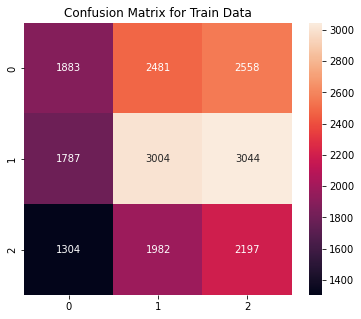

Train Accuracy: 35.00 %
Train Precision: 35.42 %
Train Recall: 35.20 %


In [ ]:
train_acc = accuracy_score(train_data.sentiment_labels, preds_train.numpy())
train_prc = precision_score(train_data.sentiment_labels, preds_train.numpy(), average='macro')
train_rcl = recall_score(train_data.sentiment_labels, preds_train.numpy(), average='macro')
train_cf = confusion_matrix(train_data.sentiment_labels, preds_train.numpy())

plt.figure(figsize=(6, 5))
sns.heatmap(train_cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Train Data')
plt.show()

print(f"Train Accuracy: {train_acc*100:.2f} %")
print(f"Train Precision: {train_prc*100:.2f} %")
print(f"Train Recall: {train_rcl*100:.2f} %")

In [ ]:
preds_dev = torch.zeros(len(dev_data))
for i in range(len(dev_data)):
    preds_dev[i] = face_sentiment_detector(dev_data[i][0], CNN_AUG, class_weights)[0].argmax()

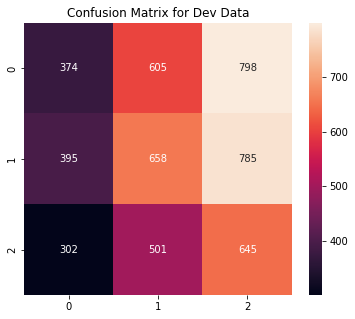

Dev Accuracy: 33.12 %
Dev Precision: 33.72 %
Dev Recall: 33.80 %


In [ ]:
dev_acc = accuracy_score(dev_data.sentiment_labels, preds_dev.numpy())
dev_prc = precision_score(dev_data.sentiment_labels, preds_dev.numpy(), average='macro')
dev_rcl = recall_score(dev_data.sentiment_labels, preds_dev.numpy(), average='macro')
dev_cf = confusion_matrix(dev_data.sentiment_labels, preds_dev.numpy())

plt.figure(figsize=(6, 5))
sns.heatmap(dev_cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Dev Data')
plt.show()

print(f"Dev Accuracy: {dev_acc*100:.2f} %")
print(f"Dev Precision: {dev_prc*100:.2f} %")
print(f"Dev Recall: {dev_rcl*100:.2f} %")

In [ ]:
preds_test = torch.zeros(len(test_data))
for i in range(len(test_data)):
    preds_test[i] = face_sentiment_detector(test_data[i][0], CNN_AUG, class_weights)[0].argmax()

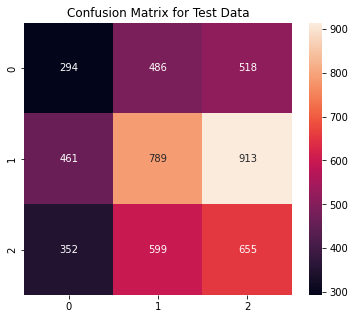

Test Accuracy: 34.30 %
Test Precision: 33.35 %
Test Recall: 33.30 %


In [ ]:
test_acc = accuracy_score(test_data.sentiment_labels, preds_test.numpy())
test_prc = precision_score(test_data.sentiment_labels, preds_test.numpy(), average='macro')
test_rcl = recall_score(test_data.sentiment_labels, preds_test.numpy(), average='macro')
test_cf = confusion_matrix(test_data.sentiment_labels, preds_test.numpy())

plt.figure(figsize=(6, 5))
sns.heatmap(test_cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Test Data')
plt.show()

print(f"Test Accuracy: {test_acc*100:.2f} %")
print(f"Test Precision: {test_prc*100:.2f} %")
print(f"Test Recall: {test_rcl*100:.2f} %")

We can see that in both cases, the overall accuracy is decreased. This may be due to the fact that our model is not very good at sentiment prediction in the first place, and as we know, data augmentation is a regularization method and can help a model to generalize better, which is not the case in this project.

## Part 2: Sentiment Analysis Using Features of the Whole Image

#### Step 1: Loading a Pretrained Model and Modifying It’s FC Layer

In this step, we load the ViT-B-16 model with pre-trained weights on IMAGENET1K_V1, which has a very high accuracy on the imagenet dataset. Then add an FC layer that is suitable for sentiment classification.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [ ]:
based_model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)
# Freeze all parameters    
for param in based_model.parameters():
    param.requires_grad = False   
# Modified FC layers
based_model.heads = nn.Sequential(
               nn.Linear(768, 128),
               nn.ReLU(),
               nn.Linear(128, 32),
               nn.ReLU(),
               nn.Linear(32, 3),
               nn.Softmax(dim=1)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

Define a train and test Transform, which resizes an image to 224×224, which is suitable for the ViT-B-16 input data. (We can also use some transformations to augment our dataset.)

In [ ]:
# Define a train and test Transform:
train_transforms = T.transforms.Compose(
        [
        #  ToPILImage(),
         Resize([224, 224]),
        #  RandomHorizontalFlip(),
        #  ColorJitter(brightness=.2, hue=.1),
        #  GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1)),
        #  RandomRotation(degrees=15),
        #  ToTensor()
        ])

test_transforms = T.transforms.Compose(
        [
        #  ToPILImage(),
         Resize([224, 224]),
        #  ToTensor()
         ])

Load data according to the transforms from the MSCTD dataset.

In [ ]:
# Instantiate a MSCTD object for each part of the dataset.
train_data = MSCTD(data_path='./data', partition='train', transform=train_transforms, get_mode='utterance')
dev_data = MSCTD(data_path='./data', partition='dev',  transform=test_transforms, get_mode='utterance')
test_data = MSCTD(data_path='./data', partition='test',  transform=test_transforms, get_mode='utterance')

Compute each class weight on train data to use in the loss function.

In [ ]:
# Computing class weights to balance training and validate data:
train_class_count = np.unique(train_data.sentiment_labels, return_counts=True)[1]

weight_tr = len(train_data.sentiment_labels) / (3*train_class_count)
d = {}
for A, B in zip(np.array([0,1,2]), weight_tr):
    d[A] = B
print(f"class weigths on train data:{d}")
class_weights_tr = torch.tensor(weight_tr,dtype=torch.float).to(device)

class weigths on train data:{0: 0.9746701338726765, 1: 0.8610933843863008, 2: 1.2304699373822117}


#### Step 2: Training the Network

Define train and test loop according to the pytorch.

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = 0
    for batch, (X, _, y) in enumerate(dataloader):
        X=(X/255).to(device)
        y=y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(X)
        if batch % 50 == 0:
            current = batch * len(X)
            print(f"loss: {running_loss/((batch+1)*len(X)):>7f}  [{current:>5d}/{size:>5d}]")


def eval_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for X, _, y in dataloader:
            X=(X/255).to(device)
            y=y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y).item() * X.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    valid_loss /= size
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Average loss: {valid_loss:>8f} \n")

Training and validating FC layer of based model for 5 epochs with adam optimizer.

In [ ]:
batch_size = 128
lr = 1e-4
epochs = 5
# Creating data loader
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=2)
dev_dataloader = DataLoader(dev_data, shuffle=True, batch_size=batch_size, num_workers=2)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=batch_size, num_workers=2)
# Defining optimizer using Adam.
optimizer = torch.optim.Adam(based_model.parameters(), lr=lr)
# Defining loss function with obtained class weights.
loss_fn_tr = nn.CrossEntropyLoss(weight=class_weights_tr, reduction='mean')
loss_fn_eval = nn.CrossEntropyLoss(reduction='mean')
# Training:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    based_model.train()
    train_loop(train_dataloader, based_model, loss_fn_tr, optimizer)
    print("Validation Results:")
    based_model.eval()
    eval_loop(dev_dataloader, based_model, loss_fn_eval)
print("Done!")

Epoch 1
-------------------------------
loss: 1.096256  [    0/20240]
loss: 1.098709  [ 6400/20240]
loss: 1.098396  [12800/20240]
loss: 1.098165  [19200/20240]
Validation Results:
Accuracy: 36.6%, Average loss: 1.097302 

Epoch 2
-------------------------------
loss: 1.097071  [    0/20240]
loss: 1.096280  [ 6400/20240]
loss: 1.095783  [12800/20240]
loss: 1.095552  [19200/20240]
Validation Results:
Accuracy: 36.9%, Average loss: 1.096438 

Epoch 3
-------------------------------
loss: 1.091276  [    0/20240]
loss: 1.093356  [ 6400/20240]
loss: 1.092692  [12800/20240]
loss: 1.092759  [19200/20240]
Validation Results:
Accuracy: 36.7%, Average loss: 1.095431 

Epoch 4
-------------------------------
loss: 1.079034  [    0/20240]
loss: 1.090416  [ 6400/20240]
loss: 1.088979  [12800/20240]
loss: 1.088580  [19200/20240]
Validation Results:
Accuracy: 35.7%, Average loss: 1.095782 

Epoch 5
-------------------------------
loss: 1.074898  [    0/20240]
loss: 1.085874  [ 6400/20240]
loss: 1.0844

In [ ]:
# Saving the trained model.
torch.save(based_model, './model_based.h5')

#### Step 3: Performance Evaluation of the Model

In [ ]:
# Loading trained model from drive.
!gdown 1apY_I_gQX6OVZZxhkObB5GOqE7goNnW9

# Check if CUDA is available. 
if torch.cuda.is_available():
    model_vit = torch.load("./model_based.h5")
else:
    model_vit = torch.load("./model_based.h5", map_location=torch.device('cpu'))

Downloading...
From: https://drive.google.com/uc?id=1apY_I_gQX6OVZZxhkObB5GOqE7goNnW9
To: /content/model_based.h5
100% 344M/344M [00:02<00:00, 166MB/s]


In [ ]:
# Evaluate the model.
model_vit.eval()
print("Evaluation results for train data:")
eval_loop(train_dataloader, model_vit, loss_fn_eval)
print("Evaluation results for dev data:")
eval_loop(dev_dataloader, model_vit, loss_fn_eval)
print("Evaluation results for test data:")
eval_loop(test_dataloader, model_vit, loss_fn_eval)

Evaluation results for train data:
Accuracy: 43.9%, Average loss: 1.076216 

Evaluation results for dev data:
Accuracy: 36.2%, Average loss: 1.095664 

Evaluation results for test data:
Accuracy: 37.8%, Average loss: 1.093462 



And finally, we calculate the confusion matrix, precision, and recall for our model.

In [ ]:
preds_train = torch.zeros(len(train_data))
for i in range(len(train_data)):
    with torch.no_grad():
        preds_train[i] = model_vit((train_data[i][0][None,...]/255).to(device)).argmax()

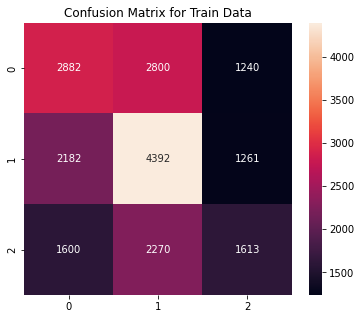

Train Accuracy: 43.91 %
Train Precision: 42.96 %
Train Recall: 42.37 %


In [ ]:
train_acc = accuracy_score(train_data.sentiment_labels, preds_train.numpy())
train_prc = precision_score(train_data.sentiment_labels, preds_train.numpy(), average='macro')
train_rcl = recall_score(train_data.sentiment_labels, preds_train.numpy(), average='macro')
train_cf = confusion_matrix(train_data.sentiment_labels, preds_train.numpy())

plt.figure(figsize=(6, 5))
sns.heatmap(train_cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Train Data')
plt.show()

print(f"Train Accuracy: {train_acc*100:.2f} %")
print(f"Train Precision: {train_prc*100:.2f} %")
print(f"Train Recall: {train_rcl*100:.2f} %")

In [ ]:
preds_dev = torch.zeros(len(dev_data))
for i in range(len(dev_data)):
    with torch.no_grad():
        preds_dev[i] = model_vit((dev_data[i][0][None,...]/255).to(device)).argmax()

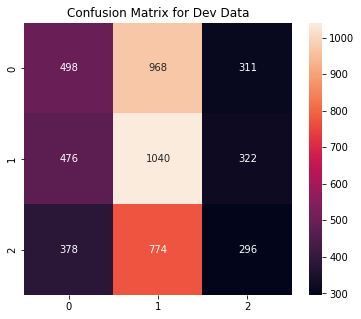

Dev Accuracy: 36.22 %
Dev Precision: 35.36 %
Dev Recall: 35.02 %


In [ ]:
dev_acc = accuracy_score(dev_data.sentiment_labels, preds_dev.numpy())
dev_prc = precision_score(dev_data.sentiment_labels, preds_dev.numpy(), average='macro')
dev_rcl = recall_score(dev_data.sentiment_labels, preds_dev.numpy(), average='macro')
dev_cf = confusion_matrix(dev_data.sentiment_labels, preds_dev.numpy())

plt.figure(figsize=(6, 5))
sns.heatmap(dev_cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Dev Data')
plt.show()

print(f"Dev Accuracy: {dev_acc*100:.2f} %")
print(f"Dev Precision: {dev_prc*100:.2f} %")
print(f"Dev Recall: {dev_rcl*100:.2f} %")

In [ ]:
preds_test = torch.zeros(len(test_data))
for i in range(len(test_data)):
    with torch.no_grad():
        preds_test[i] = model_vit((test_data[i][0][None,...]/255).to(device)).argmax()

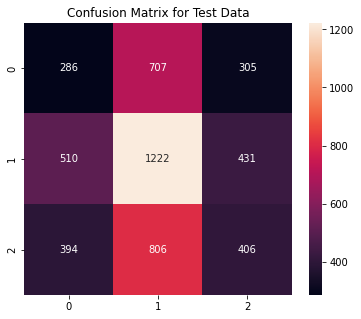

Test Accuracy: 37.77 %
Test Precision: 34.76 %
Test Recall: 34.60 %


In [ ]:
test_acc = accuracy_score(test_data.sentiment_labels, preds_test.numpy())
test_prc = precision_score(test_data.sentiment_labels, preds_test.numpy(), average='macro')
test_rcl = recall_score(test_data.sentiment_labels, preds_test.numpy(), average='macro')
test_cf = confusion_matrix(test_data.sentiment_labels, preds_test.numpy())

plt.figure(figsize=(6, 5))
sns.heatmap(test_cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Test Data')
plt.show()

print(f"Test Accuracy: {test_acc*100:.2f} %")
print(f"Test Precision: {test_prc*100:.2f} %")
print(f"Test Recall: {test_rcl*100:.2f} %")

Although vision transformers are very powerful networks for classification tasks, the test results show that the accuracy of this model is lower on our test data compared to our CNN model. (However, the train and dev accuracy is slightly higher than that of the CNN model.)

## Part 3: Sentiment Analysis by Combining the Two Methods

In this part, we define a function that takes face_sentiment, image_sentiment, face_num, and a classifier and predicts the final sentiment label of an image.

In [ ]:
def sentiment_detector(face_sentiment, image_sentiment, face_num, clf):
    X = torch.cat((face_sentiment, image_sentiment, torch.tensor(face_num).view(1)))
    y = clf.predict(X.view(1, -1))
    return y

First, we create a new dataset to train our classifier.

In [ ]:
X_train = torch.zeros((len(train_data), 7))
y_train = torch.zeros((len(train_data)))

for i in range(len(train_data)):
    with torch.no_grad():
        train_data.transform = None
        X_train[i, 0:3], X_train[i, 6] = face_sentiment_detector(train_data[i][0], CNN, class_weights)
        train_data.transform = test_transforms
        X_train[i, 3:6] = model_vit((train_data[i][0][None,...]/255).to(device))

    y_train[i] = train_data[i][2]

Now we train an SVM as our classifier on our training data.

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', C=3.2))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=3.2, gamma='auto'))])

We can now evaluate the predicted sentiment labels.

In [ ]:
preds_train = clf.predict(X_train)

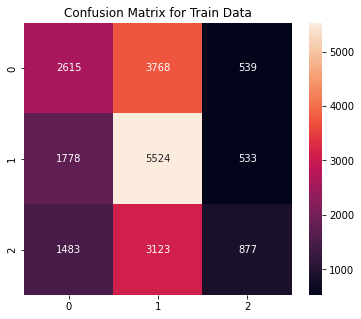

Train Accuracy: 44.55 %
Train Precision: 44.67 %
Train Recall: 41.43 %


In [ ]:
train_acc = accuracy_score(train_data.sentiment_labels, preds_train)
train_prc = precision_score(train_data.sentiment_labels, preds_train, average='macro')
train_rcl = recall_score(train_data.sentiment_labels, preds_train, average='macro')
train_cf = confusion_matrix(train_data.sentiment_labels, preds_train)

plt.figure(figsize=(6, 5))
sns.heatmap(train_cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Train Data')
plt.show()

print(f"Train Accuracy: {train_acc*100:.2f} %")
print(f"Train Precision: {train_prc*100:.2f} %")
print(f"Train Recall: {train_rcl*100:.2f} %")

In [ ]:
preds_dev = np.zeros(len(dev_data))
for i in range(len(dev_data)):
    with torch.no_grad():
        dev_data.transform = None
        face_sentiment, face_num = face_sentiment_detector(dev_data[i][0], CNN, class_weights)
        dev_data.transform = test_transforms
        image_sentiment =  model_vit((dev_data[i][0][None,...]/255).to(device)).to('cpu')
    preds_dev[i] = sentiment_detector(face_sentiment, image_sentiment[0], face_num, clf)

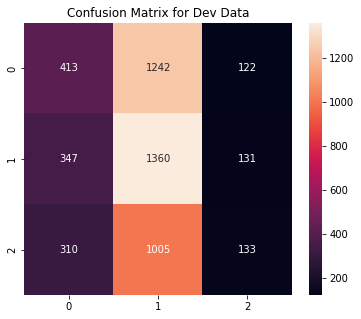

Dev Accuracy: 37.65 %
Dev Precision: 36.92 %
Dev Recall: 35.47 %


In [ ]:
dev_acc = accuracy_score(dev_data.sentiment_labels, preds_dev)
dev_prc = precision_score(dev_data.sentiment_labels, preds_dev, average='macro')
dev_rcl = recall_score(dev_data.sentiment_labels, preds_dev, average='macro')
dev_cf = confusion_matrix(dev_data.sentiment_labels, preds_dev)

plt.figure(figsize=(6, 5))
sns.heatmap(dev_cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Dev Data')
plt.show()

print(f"Dev Accuracy: {dev_acc*100:.2f} %")
print(f"Dev Precision: {dev_prc*100:.2f} %")
print(f"Dev Recall: {dev_rcl*100:.2f} %")

In [ ]:
preds_test = np.zeros(len(test_data))
for i in range(len(test_data)):
    with torch.no_grad():
        test_data.transform = None
        face_sentiment, face_num = face_sentiment_detector(test_data[i][0], CNN, class_weights)
        test_data.transform = test_transforms
        image_sentiment =  model_vit((test_data[i][0][None,...]/255).to(device)).to('cpu')
    preds_test[i] = sentiment_detector(face_sentiment, image_sentiment[0], face_num, clf)

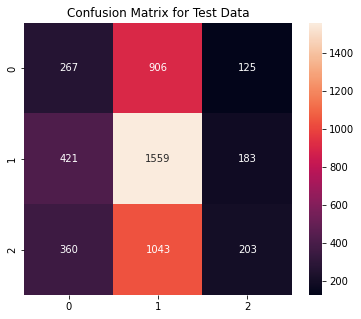

Test Accuracy: 40.04 %
Test Precision: 36.55 %
Test Recall: 35.10 %


In [ ]:
test_acc = accuracy_score(test_data.sentiment_labels, preds_test)
test_prc = precision_score(test_data.sentiment_labels, preds_test, average='macro')
test_rcl = recall_score(test_data.sentiment_labels, preds_test, average='macro')
test_cf = confusion_matrix(test_data.sentiment_labels, preds_test)

plt.figure(figsize=(6, 5))
sns.heatmap(test_cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for Test Data')
plt.show()

print(f"Test Accuracy: {test_acc*100:.2f} %")
print(f"Test Precision: {test_prc*100:.2f} %")
print(f"Test Recall: {test_rcl*100:.2f} %")

As can be seen, our final results are:

|            | Accuracy | Precision | Recall  |
|------------|----------|-----------|---------|
| Train Data | 44.55 %  | 44.67 %   | 41.43 % |
| Dev Data   | 37.65 %  | 36.92 %   | 35.47 % |
| Test Data  | 40.04 %  | 36.55 %   | 35.10 % |